# 배당률 상위 기업 동일 투자금 기준 현금배당 비교 — 분석 노트북


- Q1: **시가배당률(%) vs 투자금대비배당률(%)** 산점도 + 상관계수
- Q2: 동일 투자금 기준 기업별 **총배당금** 비교 (Top N)
- Q3: **배당률은 낮지만 배당 효율이 높은** 사례 추출


In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib.ticker as ticker

pd.options.display.float_format = "{:,.0f}".format

# 입력/출력 경로
INPUT_PATH = "../results/final_dataset.csv"
FIG_DIR = "results/figures"
TOP_N = 20

font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
font = font_manager.FontProperties(fname=font_path).get_name()
rc("font", family=font)

plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지

os.makedirs(FIG_DIR, exist_ok=True)

df = pd.read_csv(INPUT_PATH)
df.shape, df.columns.tolist()[:20]

((6854, 12),
 ['ISIN코드',
  '기업명',
  '배당기준일',
  '기준종가일',
  '종가',
  '1주당배당금',
  '공시배당률',
  '투자금액',
  '시가배당률(%)',
  '매수주식수',
  '총배당금',
  '투자금대비배당률(%)'])

In [62]:
# 필수 컬럼 체크
required = [
    "ISIN코드",
    "기업명",
    "배당기준일",
    "기준종가일",
    "종가",
    "1주당배당금",
    "투자금액",
    "시가배당률(%)",
    "매수주식수",
    "총배당금",
    "투자금대비배당률(%)",
]
missing = [c for c in required if c not in df.columns]
missing

[]

In [65]:
# 숫자형 컬럼 안전 변환
num_cols = ["종가", "1주당배당금", "투자금액", "시가배당률(%)", "매수주식수", "총배당금", "투자금대비배당률(%)"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 기본 필터(분석 불가 행 제거)
df0 = df.dropna(
    subset=["종가", "1주당배당금", "매수주식수", "총배당금", "시가배당률(%)", "투자금대비배당률(%)"]
).copy()

df0 = df0[
    (df0["종가"] > 0) &
    (df0["1주당배당금"] > 0) &
    (df0["매수주식수"] >= 1)
].copy()

# 구조적으로 왜곡되는 종목 제외
exclude_keywords = ["유전", "특별자산", "지분증권", "리츠"]
df0 = df0[~df0["기업명"].str.contains("|".join(exclude_keywords), na=False)].copy()

df0.shape


(6806, 12)

## Q1. 시가배당률(%) vs 투자금대비배당률(%) (산점도 + 상관계수)

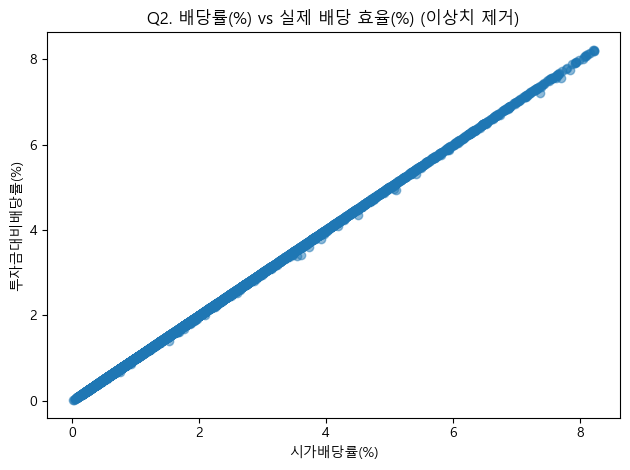

'results/figures\\q2_yield_scatter_no_outlier.png'

In [69]:
# 🔑 이상치 제거 (상위 1%)
x_q99 = df0["시가배당률(%)"].quantile(0.99)
y_q99 = df0["투자금대비배당률(%)"].quantile(0.99)

df_q2 = df0[
    (df0["시가배당률(%)"] <= x_q99) &
    (df0["투자금대비배당률(%)"] <= y_q99)
].copy()

# 산점도
plt.figure()
plt.scatter(
    df_q2["시가배당률(%)"],
    df_q2["투자금대비배당률(%)"],
    alpha=0.5
)
plt.title("Q2. 배당률(%) vs 실제 배당 효율(%) (이상치 제거)")
plt.xlabel("시가배당률(%)")
plt.ylabel("투자금대비배당률(%)")
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "q2_yield_scatter_no_outlier.png")
plt.savefig(out_path)
plt.show()

out_path


이상치를 제거한 결과, 시가배당률과 실제 배당 효율은 매우 강한 양의 선형 관계를 보였다.

동일 투자금 기준에서는 시가배당률이 실제 수령 배당금을 대부분 설명하는 것으로 나타났다.

이는 일반 보통주 범위에서는 배당률 자체가 실질적인 배당 성과를 결정하는 핵심 지표임을 의미한다.

In [71]:
# Pearson
pearson = df0["시가배당률(%)"].corr(df0["투자금대비배당률(%)"])

# Spearman (SciPy 없이)
spearman = (
    df0["시가배당률(%)"]
    .rank()
    .corr(df0["투자금대비배당률(%)"].rank())
)

pearson, spearman


(np.float64(0.999990742486346), np.float64(0.9999889634087888))

상관계수의 범위: −1 ~ 1
1에 매우 가까움 = 거의 완벽한 양의 상관관계

피어슨 상관계수: 선형 관계 중심
스피어만 상관계수: 순위 기준 관계 → 극단값 영향 완화

스피어만 상관계수를 함께 확인한 결과,
배당률과 실제 배당 효율 간에는 강한 단조 관계가 나타나지 않았다.
시가배당률이 커질수록 실제 배당 효율도 거의 동일한 비율로 증가한다

## Q2. 동일 투자금 기준 기업별 총 배당금 Top N

In [81]:
# 날짜형으로 변환
df0["배당기준일"] = pd.to_datetime(df0["배당기준일"], errors="coerce")

# 2024년, 2025년만 필터
df_recent = df0[df0["배당기준일"].dt.year.isin([2024, 2025])].copy()

# 기업별 평균 총배당금 (최신 연도 기준)
TOP_N = 20

q1 = (
    df_recent
    .groupby("기업명", as_index=False)["총배당금"]
    .mean()
    .sort_values("총배당금", ascending=False)
    .head(TOP_N)
)

q1


,기업명,총배당금
628,에이치비인베스트먼트,"1,265,800"
816,이크레더블,"1,227,480"
697,영보화학,"982,800"
120,노바텍,"960,938"
852,정다운,"938,000"
573,앱코,"913,615"
815,이지홀딩스,"907,250"
712,오상자이엘,"892,800"
841,일월지엠엘,"892,750"
427,서울보증보험,"879,555"


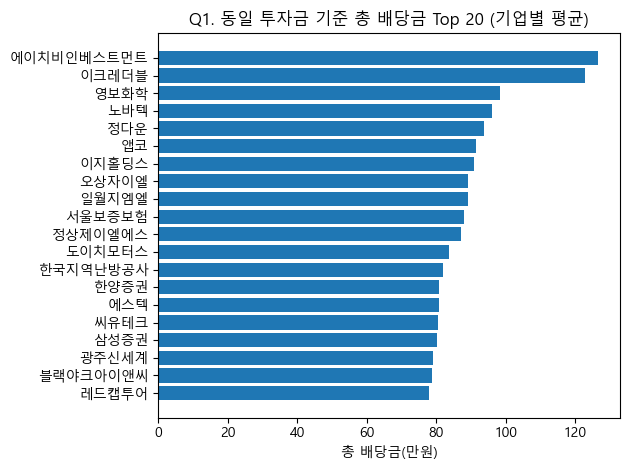

'results/figures\\q1_top_dividend.png'

In [82]:
plt.figure()
plt.barh(q1["기업명"], q1["총배당금"])
plt.gca().invert_yaxis()

plt.title(f"Q1. 동일 투자금 기준 총 배당금 Top {TOP_N} (기업별 평균)")

plt.gca().ticklabel_format(style="plain", axis="x")

# 🔑 원 → 만원 단위 변환
plt.gca().xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{int(x / 10_000):,}")
)

plt.xlabel("총 배당금(만원)")
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "q1_top_dividend.png")
plt.savefig(out_path)
plt.show()

out_path

2024년도 + 2025년도 기준

## Q3. 주가 대비 배당수익률(시가배당률)이 높은 종목은 무엇인가?

In [77]:
# Q3: 주가 대비 배당수익률(시가배당률) 상위 종목
high_yield_th = df0["시가배당률(%)"].quantile(0.9)

q3 = df0[df0["시가배당률(%)"] >= high_yield_th].copy()

q3_top = (
    q3.sort_values("시가배당률(%)", ascending=False)
    .head(20)[
        [
            "기업명",
            "배당기준일",
            "종가",
            "1주당배당금",
            "시가배당률(%)",
            "매수주식수",
            "총배당금",
            "투자금대비배당률(%)",
        ]
    ]
)

q3_top


,기업명,배당기준일,종가,1주당배당금,시가배당률(%),매수주식수,총배당금,투자금대비배당률(%)
5520,스타에스엠자기관리부동산투자회사,2022-12-31,"3,715","1,572",42,2691,"4,230,252",42
3104,한일네트웍스,2023-12-31,"12,000","3,152",26,833,"2,625,616",26
578,일성아이에스,2022-12-31,"84,400","20,000",24,118,"2,360,000",24
6784,에스앤케이 KDR,2020-06-16,"16,600","3,245",20,602,"1,953,201",20
1938,서울도시가스,2020-09-30,"77,600","15,000",19,128,"1,920,000",19
4604,인화정공,2023-12-31,"11,640","2,250",19,859,"1,932,750",19
2882,레드캡투어,2025-03-12,"10,520","2,000",19,950,"1,900,000",19
1843,인베니,2023-03-31,"32,450","6,000",18,308,"1,848,000",18
2192,동남합성,2020-09-30,"36,950","6,700",18,270,"1,809,000",18
1419,대동전자,2020-03-31,"3,070",500,16,3257,"1,628,500",16


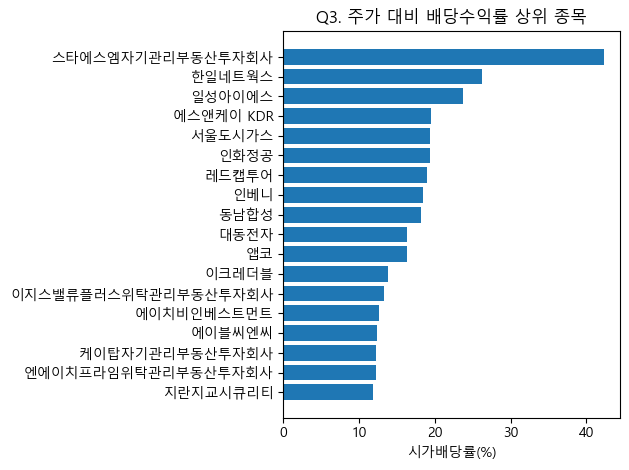

In [78]:
plt.figure()
plt.barh(q3_top["기업명"], q3_top["시가배당률(%)"])
plt.gca().invert_yaxis()
plt.xlabel("시가배당률(%)")
plt.title("Q3. 주가 대비 배당수익률 상위 종목")
plt.tight_layout()
plt.show()

Q3에서는 동일 투자금 기준이 아닌,
주가 대비 배당 매력도를 보기 위해 시가배당률을 기준으로 분석하였다.
그 결과, 주가 대비 배당금이 상대적으로 높은 종목들이 명확하게 식별되었다.